# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

#import cell2location.models as c2l
#import cell2location.plt as c2lpl
#import cell2location.cluster_averages 
import cell2location
import pymc3 as pm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

## Read datasets and train cell2location

In [3]:
adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata.uns['spatial'] = {'x': 'y'}

adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

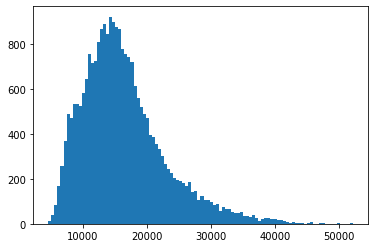

In [4]:
plt.hist(np.array(adata.X.sum(1)).flatten(), bins=100);

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True) 

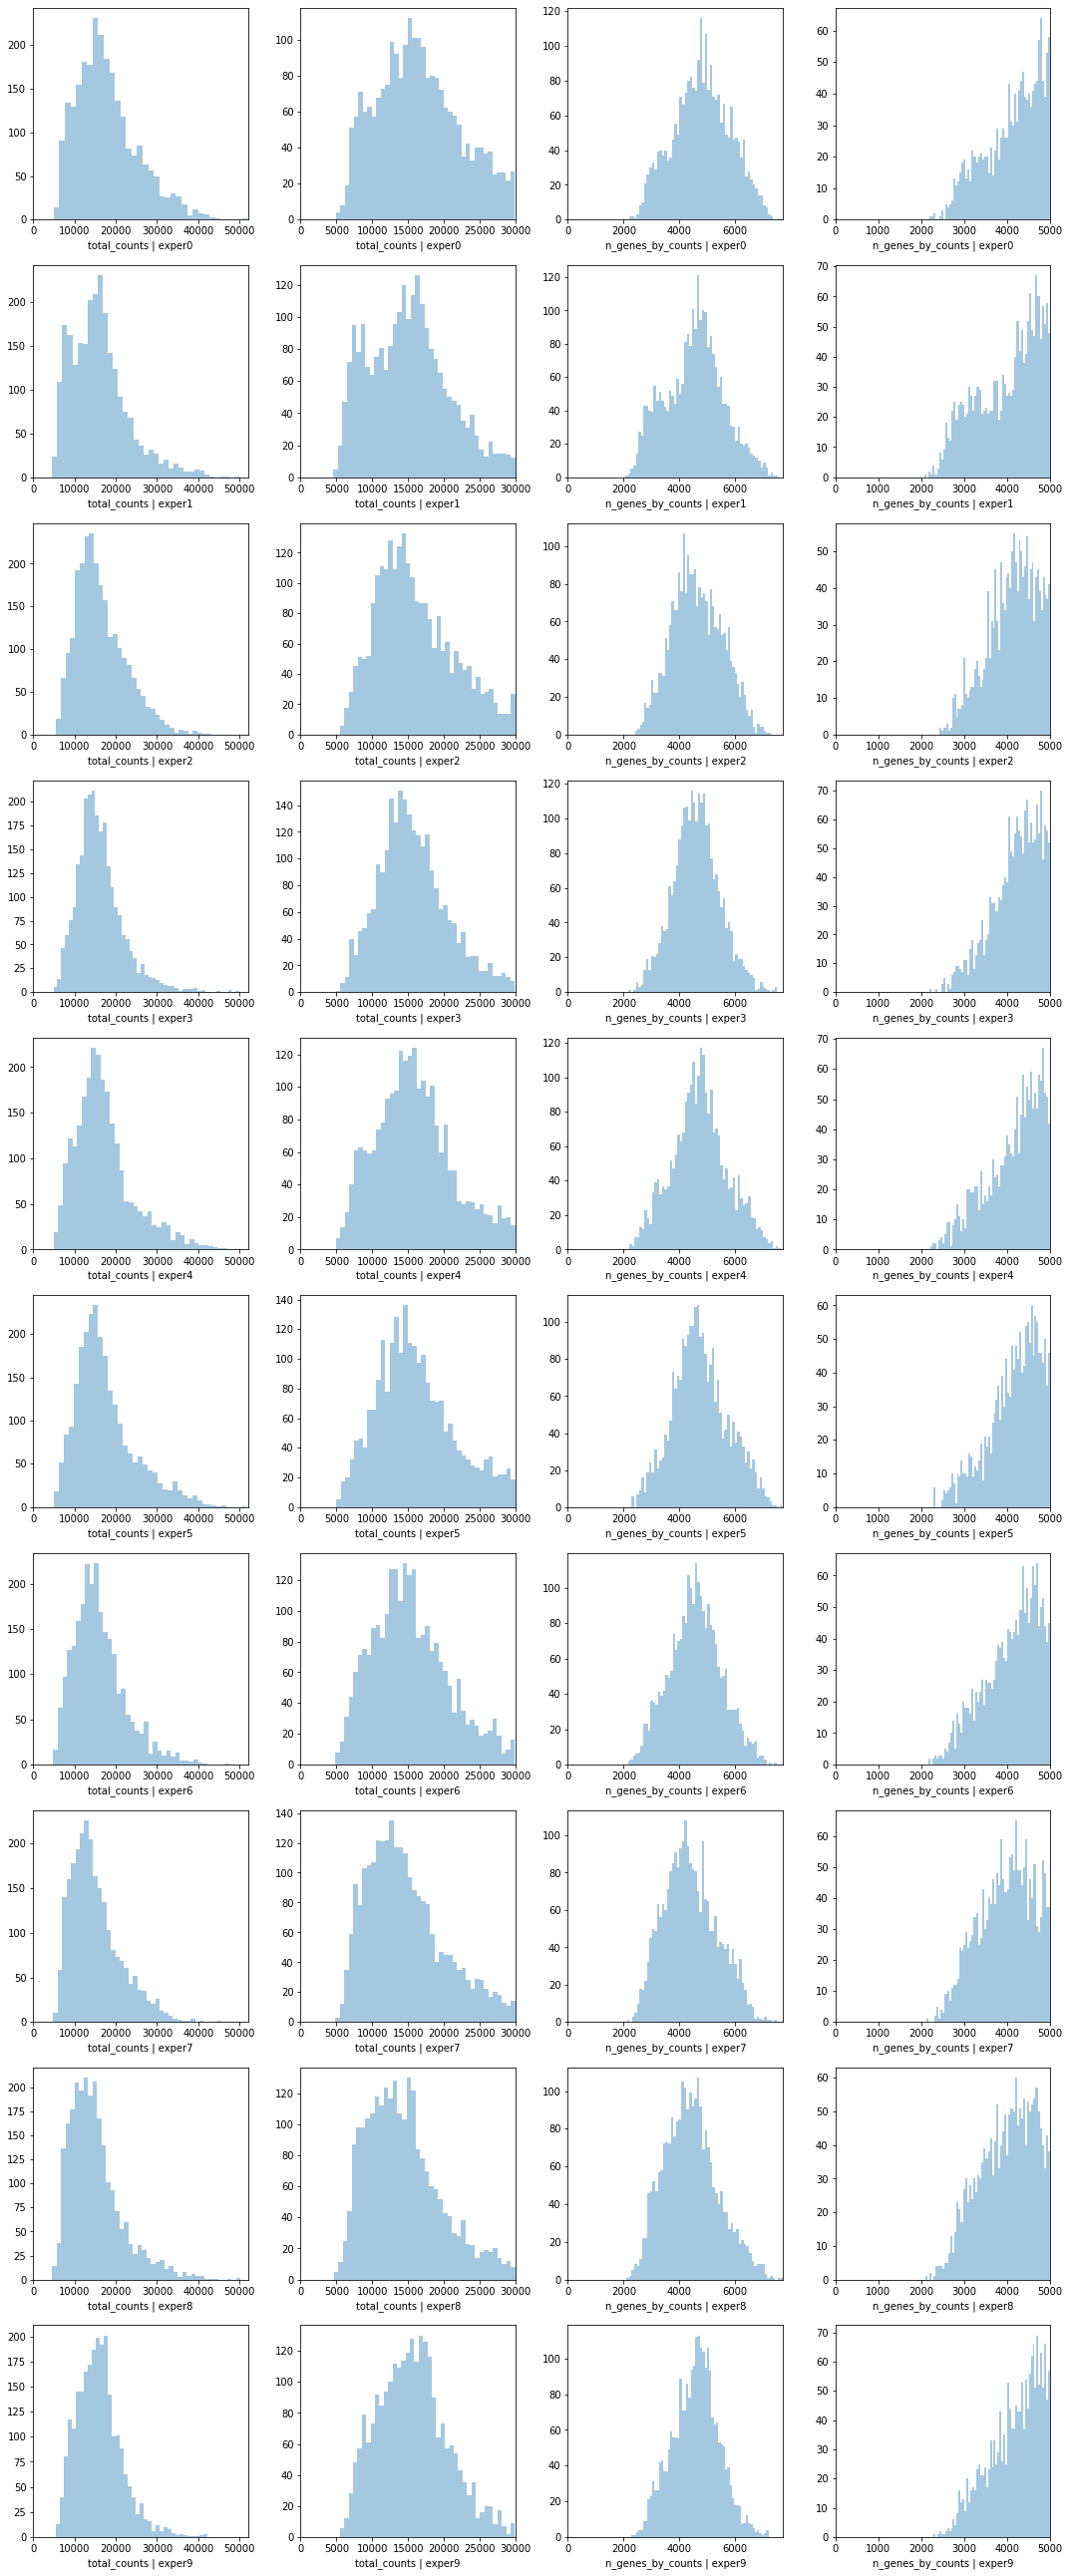

In [6]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(adata.obs['sample'].unique()), 4, figsize=(15, 4*len(adata.obs['sample'].unique())-4))
#axs = axs.reshape((len(adata.obs['sample'].unique()), 4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    #slide = select_slide(adata, s)
    slide = adata[adata.obs['sample'] == s]
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<30000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 30000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<5000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 5000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

In [7]:
import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)

In [8]:
import scipy
adata.X = scipy.sparse.csr_matrix(adata.X)

Select genes using expression in non-zero cells

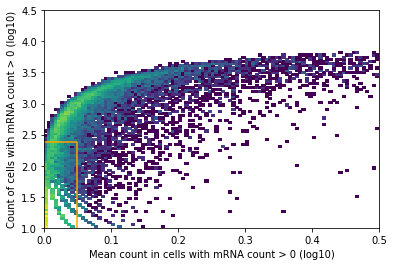

In [9]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [10]:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(8111, 12422)

In [11]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]

In [12]:
adata_snrna_raw

View of AnnData object with n_obs × n_vars = 8111 × 12422
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

Add counts matrix as `adata.raw` 

In [13]:
adata_snrna_raw.raw = adata_snrna_raw

In [14]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [15]:
adata_vis.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000033845',
       'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
       'ENSMUSG00000025905', 'ENSMUSG00000025907', 'ENSMUSG00000090031',
       'ENSMUSG00000033740',
       ...
       'ENSMUSG00000024993', 'ENSMUSG00000063698', 'ENSMUSG00000024997',
       'ENSMUSG00000003228', 'ENSMUSG00000074733', 'ENSMUSG00000059326',
       'ENSMUSG00000051412', 'ENSMUSG00000079834', 'ENSMUSG00000095041',
       'ENSMUSG00000063897'],
      dtype='object', name='ENSEMBL', length=12809)

In [16]:
adata_vis.var

,gene_level,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSEMBL,,,,,,,
ENSMUSG00000051951,0.003928,4909,0.22492,0.202876,80.364,5623,8.634798
ENSMUSG00000089699,0.000026,5,0.00020,0.000200,99.980,5,1.791759
ENSMUSG00000033845,0.697608,13989,1.10868,0.746062,44.044,27717,10.229837
ENSMUSG00000033813,0.430858,11230,0.71892,0.541696,55.080,17973,9.796682
ENSMUSG00000002459,0.070863,14567,0.95816,0.672005,41.732,23954,10.083932
...,...,...,...,...,...,...,...
ENSMUSG00000059326,0.064865,5380,0.25412,0.226434,78.480,6353,8.756840
ENSMUSG00000051412,0.801130,9856,0.66184,0.507925,60.576,16546,9.713960
ENSMUSG00000079834,0.008582,584,0.02376,0.023482,97.664,594,6.388561


In [17]:
from re import sub
adata_snrna_raw.obs['sample'] = [sub('_.+$','', i) for i in adata_snrna_raw.obs.index]

### First, infer average expression in each cell type

In [18]:
adata_snrna_raw

AnnData object with n_obs × n_vars = 8111 × 12422
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

```python
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, 
                                    
                   verbose=True, return_all=True,
                                 
                   train_args={
                    'covariate_col_names': ['annotation_1'], 
                    'sample_name_col': 'sample',
                    'tech_id': None,
                    'stratify_cv': 'annotation_1',
                       
                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,
                       
                    'use_average_as_initial_value': True, 'use_cuda': True,
                       
                    'train_proportion': 0.9,
                    'l2_weight': {'l2_weight': 0.001, 'sample_scaling_weight': 0.5,
                           'gene_overdisp_weight': 0.1},  # True = use defaults for the model
                    
                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},
                                 
                   model_kwargs={},
                   posterior_args={},
                                 
                   export_args={'path': results_folder + 'regression_model/', 'save_model': True,
                                'run_name_suffix': 'with_tissue_zones'})

reg_mod = r['mod']
#adata_snrna_raw = r['sc_data']
```

In [19]:
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_51covariates_8111cells_12422geneswith_tissue_zones'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']
#r_reg = pickle.load(file = open(f'{reg_path}model_settings.p', "rb"))
#r_reg

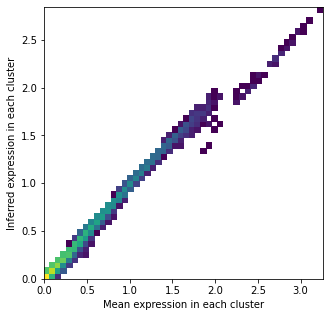

In [20]:
# export inferred averages in each cluster
inf_aver = pd.DataFrame(#adata_snrna_raw.uns['regression_mod']['post_sample_q05']['gene_factors'].T,
                        adata_snrna_raw.uns['regression_mod']['post_sample_means']['gene_factors'].T,
             index=adata_snrna_raw.uns['regression_mod']['var_names'], 
             columns=adata_snrna_raw.uns['regression_mod']['fact_names'])
inf_aver = inf_aver.loc[:, np.array(['annotation_1_' in i for i in inf_aver.columns])]
from re import sub
inf_aver.columns = [sub('annotation_1_', '', i) for i in inf_aver.columns]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# export inferred averages in each cluster
#inf_aver = reg_mod.covariate_effects.copy()
#from re import sub
#inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]
#inf_aver = inf_aver.loc[aver.index, aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

In [21]:
inf_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_THAL_lat,Astro_THAL_med,Astro_WM,Ext_Amy_1,Ext_Amy_2,...,Inh_Vip,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1
ENSMUSG00000051951,0.012509,0.030425,1.005507e-02,5.359366e-02,0.008253,0.064003,0.045352,1.762414e-02,15.928912,12.917710,...,4.795861,4.528843,2.080448e-02,1.473291,2.662451e-01,1.672836,0.397386,1.551169,0.560366,1.006497
ENSMUSG00000089699,0.006211,0.004515,7.332511e-09,7.822795e-09,0.009702,0.015000,0.012339,2.187605e-02,3.754444,2.789158,...,1.031598,1.037042,6.948521e-09,0.430513,4.540244e-02,0.342018,0.058468,0.584137,0.142750,0.188549
ENSMUSG00000033845,0.108923,0.033173,3.914691e-02,3.407474e-02,0.063219,0.099592,0.079603,7.772008e-02,0.246512,0.130134,...,0.059994,0.080287,3.278148e-02,0.089115,2.891131e-02,0.050014,0.046113,0.028590,0.039603,0.050697
ENSMUSG00000033813,0.048582,0.104406,1.285341e-01,7.109736e-02,0.039291,0.026488,0.059248,7.517914e-02,0.164718,0.177850,...,0.163613,0.230734,8.710550e-02,0.116066,6.265426e-02,0.129172,0.072901,0.050134,0.053157,0.015894
ENSMUSG00000002459,2.664850,3.067285,3.271224e+00,3.492710e+00,1.250632,1.269952,1.057511,3.244063e+00,0.768309,0.598986,...,0.266393,0.032791,9.052837e-03,0.032243,2.383682e-01,0.485955,0.054811,0.021572,0.007194,0.035584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064370,0.121929,0.101013,1.662863e-01,1.399361e-01,0.080974,0.061845,0.046601,6.084076e-01,0.317106,0.331083,...,0.171908,0.192032,4.760990e-02,0.109529,9.318745e-02,0.081206,0.180818,0.062981,0.059534,0.029104
ENSMUSG00000051412,0.080739,0.060860,5.444401e-02,1.768604e-02,0.019386,0.030146,0.037793,8.481868e-09,0.113388,0.112030,...,0.045511,0.014056,1.982695e-02,0.100616,7.969802e-09,0.054375,0.073011,0.069427,0.058386,0.018169
ENSMUSG00000079834,0.209774,0.123219,1.727202e-01,9.581321e-02,0.153563,0.193688,0.214270,8.494480e-09,0.421241,0.401686,...,0.247192,0.148152,5.136155e-02,0.087012,2.566674e-02,0.105467,0.226450,0.231909,0.072837,0.035553
ENSMUSG00000095041,0.122693,0.221602,2.658242e-01,1.983381e-01,0.203783,0.222463,0.106993,5.503593e-02,1.452682,1.678397,...,0.882560,1.862407,1.032898e+00,1.421899,3.114445e-01,0.357791,0.545915,0.192879,0.106003,0.090399


In [22]:
from cell2location.cluster_averages.cluster_averages import get_cluster_averages
from cell2location.cluster_averages.cluster_averages import get_cluster_variances
eps = 1e-8
aver = get_cluster_averages(adata_snrna_raw, 'annotation_1') + eps
variances = get_cluster_variances(adata_snrna_raw, 'annotation_1') + eps

shape = aver ** 2 / variances

## Model training

`pycell2location.run_cell2location` is a wrapper for cell2location model workflow:
We summarise single cell data, train the model, sample prior and posterior, save and export results, including diagnostic plots.

`pycell2location.run_cell2location` takes single cell and spatial anndata as input together with a bunch of parameters.

In [23]:
results_folder

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

In [24]:
adata_vis.obs['sample']

exper0_location_0       exper0
exper0_location_1       exper0
exper0_location_2       exper0
exper0_location_3       exper0
exper0_location_4       exper0
                         ...  
exper9_location_2495    exper9
exper9_location_2496    exper9
exper9_location_2497    exper9
exper9_location_2498    exper9
exper9_location_2499    exper9
Name: sample, Length: 25000, dtype: category
Categories (10, object): ['exper0', 'exper1', 'exper2', 'exper3', ..., 'exper6', 'exper7', 'exper8', 'exper9']

In [25]:
from cell2location.models.LocationModelLinearDependentWMultiExperiment import LocationModelLinearDependentWMultiExperiment

In [26]:
np.random.seed(10)
param_vector = [1, 3, 5, 10, 14, 18, 25]
m_g_param_vector = [0.05, 0.1, 0.3, 0.5, 0.7, 1, 2]
param_list = [{k: np.random.choice(param_vector) for k in ['cells_per_spot', 'factors_per_spot', 'combs_per_spot']} 
              for i in range(100)]
for i in range(100):
    param_list[i]['gene_level_prior'] = np.random.choice(m_g_param_vector)

In [27]:
rcParams['figure.figsize'] = 5, 5
for p in param_list:
    
    r = cell2location.run_cell2location(
                          sc_data=inf_aver,
                          sp_data=adata_vis[adata_vis.obs['sample'] == 'exper0',:],
        
                          model_name=LocationModelLinearDependentWMultiExperiment,
        
                          verbose=False, return_all=False,

                          summ_sc_data_args={'cluster_col': "annotation_1"},

                          train_args={'n_iter': 30000, 'learning_rate': 0.005,
                                      'total_grad_norm_constraint': 200,
                                      'sample_prior': False, 'n_prior_samples': 20,
                                      'readable_var_name_col': None,
                                      'sample_name_col': 'sample', 'n_restarts': 1},

                          posterior_args={'n_samples': 1000},
                          export_args={'path': results_folder + 'hyperparameters/',
                                       'save_model': False, 
                                       'run_name_suffix': f'_defaults_ceps{p["cells_per_spot"]}_cps{p["combs_per_spot"]}_fps{p["factors_per_spot"]}_inf_shape01_gl{p["gene_level_prior"]}',
                                       'scanpy_coords_name': 'X_spatial'},
                          model_kwargs={
                                        'cell_number_prior': {'cells_per_spot': p["cells_per_spot"], 
                                                              'factors_per_spot': p["factors_per_spot"], 
                                                              'combs_per_spot': p["combs_per_spot"]
                                                             },
                                        'gene_level_prior': {'mean': p["gene_level_prior"], 
                                                             'sd': p["gene_level_prior"] / 2}
                          }
    )

### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps14_fps18_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1658e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps10_fps3_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1661e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps18_fps3_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1642e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps3_fps18_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1689e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps3_fps1_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1685e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps1_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1693e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps14_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1653e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps10_fps14_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1669e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1638e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps3_fps25_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1686e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps25_fps14_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1653e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps25_fps10_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1642e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps18_fps18_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.164e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps25_fps3_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1638e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps25_fps14_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1637e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps3_fps25_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1667e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps3_fps3_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1686e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps5_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1669e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps25_fps18_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1624e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps1_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1636e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps1_fps5_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1698e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1694e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps1_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1648e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps10_fps25_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1672e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps14_fps3_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1643e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps1_fps1_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.17e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps14_fps18_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1634e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps5_fps1_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1682e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps5_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1654e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps1_fps18_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1704e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps25_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1622e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps25_fps5_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1632e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps14_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1638e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps25_fps1_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1641e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps3_fps3_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1664e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps5_fps1_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1663e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps10_fps3_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1641e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps18_fps5_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1642e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps3_fps3_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1698e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps5_fps1_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1658e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps1_fps18_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.169e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps1_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1669e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps10_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.165e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps18_fps5_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.166e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps25_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1711e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps1_fps3_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.17e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps3_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1683e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps14_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1651e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps3_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1667e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps14_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1686e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps3_fps18_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1693e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps14_fps14_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1664e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps25_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1634e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps10_fps5_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.168e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps10_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1647e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps25_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.163e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps10_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1639e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps18_fps18_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1667e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps3_fps10_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1672e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps18_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.164e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps3_fps18_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.168e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps1_fps1_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1675e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps1_fps3_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1684e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps10_fps10_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1639e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps18_fps1_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1635e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps18_fps14_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1651e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps3_fps10_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1664e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps3_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.168e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps18_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1639e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps14_fps3_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1666e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps10_fps14_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1637e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps25_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1699e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps14_fps3_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1658e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps25_fps14_inf_shape01_gl2.0


Finished [100%]: Average Loss = 3.1641e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps1_fps25_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1682e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps25_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1632e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps3_fps5_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1687e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps25_fps3_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1638e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps18_fps5_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1634e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps18_fps14_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1629e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps1_fps14_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1685e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps5_fps5_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1661e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps1_fps25_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1703e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps5_fps25_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1651e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps18_fps1_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1636e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps1_fps5_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1679e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps10_fps3_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1647e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps10_fps5_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1646e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps1_fps18_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1688e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps3_fps14_inf_shape01_gl0.7


Finished [100%]: Average Loss = 3.1666e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps14_fps1_inf_shape01_gl0.3


Finished [100%]: Average Loss = 3.1646e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps18_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1628e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps18_cps25_fps14_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1636e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps14_fps3_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.1638e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps14_fps10_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1658e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps14_fps25_inf_shape01_gl0.05


Finished [100%]: Average Loss = 3.164e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps1_inf_shape01_gl1.0


Finished [100%]: Average Loss = 3.1704e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps3_fps5_inf_shape01_gl0.1


Finished [100%]: Average Loss = 3.1665e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps10_fps3_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.166e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')
### Analysis name: LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps25_cps18_fps5_inf_shape01_gl0.5


Finished [100%]: Average Loss = 3.1642e+07



Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 IndexError('index 0 is out of bounds for axis 0 with size 0')


### Read and compute R^2 and PR score

In [27]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

prefix = 'LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults'
folder_names = [f'{prefix}_ceps{p["cells_per_spot"]}_cps{p["combs_per_spot"]}_fps{p["factors_per_spot"]}_inf_shape01_gl{p["gene_level_prior"]}' for p in param_list]
res = pd.DataFrame(param_list, index=folder_names)

for i, f in enumerate(folder_names):
    
    sp_data_file = f'{results_folder}hyperparameters/{f}/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    from re import sub
    cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
    cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
    cell_count_columns = cell_count.columns
    umi_count = adata_vis_res.obs.loc[:, ['UMI_count_' in i for i in adata_vis_res.obs.columns]]
    umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

    spot_factors = adata_vis_res.obs[['mean_spot_factors' + i for i in cell_count_columns]]
    spot_factors.columns =  [sub('mean_spot_factors', '', i) for i in spot_factors.columns]
    nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
    nUMI_factors.columns =  [sub('mean_nUMI_factors', '', i) for i in nUMI_factors.columns]
    
    infer_cell_count = spot_factors[cell_count.columns]
    infer_nUMI_count = nUMI_factors[cell_count.columns]
    
    cell_proportions = (cell_count.T / cell_count.sum(1)).T
    cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    # compute R^2
    res.loc[f, 'absolute_r'] = np.corrcoef(cell_count.values.flatten(), 
                                           infer_cell_count.values.flatten())[0,1]
    res.loc[f, 'relative_r'] = np.corrcoef(cell_proportions.values.flatten(), 
                                           infer_cell_proportions.values.flatten())[0,1]
    res.loc[f, 'mRNA_r'] = np.corrcoef(umi_count.values.flatten(), 
                                       nUMI_factors.values.flatten())[0,1]
    
    # compute PR score
    pos_cell_count = cell_count.values > 0.1
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    mode = 'macro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    mode = 'micro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    
res

,cells_per_spot,factors_per_spot,combs_per_spot,gene_level_prior,absolute_r,relative_r,mRNA_r,PR_score_macro,PR_score_micro
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps14_fps18_inf_shape01_gl1.0,3,18,14,1.00,0.779747,0.692279,0.837637,0.638406,0.620199
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps10_fps3_inf_shape01_gl0.05,1,3,10,0.05,0.786034,0.656093,0.838253,0.643477,0.602731
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps14_cps18_fps3_inf_shape01_gl0.7,14,3,18,0.70,0.791426,0.742737,0.854805,0.660239,0.646021
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps1_cps3_fps18_inf_shape01_gl0.3,1,18,3,0.30,0.769727,0.651970,0.821257,0.618299,0.595200
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps3_fps1_inf_shape01_gl1.0,5,1,3,1.00,0.781038,0.698784,0.839608,0.635023,0.622234
...,...,...,...,...,...,...,...,...,...
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps5_cps14_fps25_inf_shape01_gl0.05,5,25,14,0.05,0.794248,0.731237,0.855499,0.667410,0.633237
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps1_fps1_inf_shape01_gl1.0,3,1,1,1.00,0.776160,0.683043,0.831067,0.623583,0.613417
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps10_cps3_fps5_inf_shape01_gl0.1,10,5,3,0.10,0.810607,0.758272,0.862726,0.662440,0.660215
LocationModelLinearDependentWMultiExperiment_1experiments_49clusters_2500locations_12080genes_defaults_ceps3_cps10_fps3_inf_shape01_gl0.5,3,3,10,0.50,0.784910,0.701002,0.842976,0.648399,0.624237


### Look at stability of inference for relative values

In [1]:
fig_path=f'{results_folder}hyperparameters/plots'
fig_path

NameError: name 'results_folder' is not defined

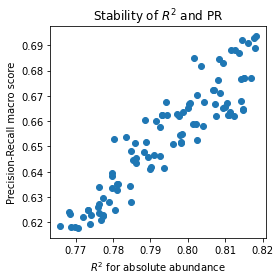

In [29]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['absolute_r'].values.flatten(), 
           res['PR_score_macro'].values.flatten());
plt.xlabel('$R^2$ for absolute abundance');
plt.ylabel('Precision-Recall macro score');
plt.title(r'Stability of $R^2$ and PR');
plt.tight_layout()
plt.savefig(fig_path + '/stability_absolute_r.pdf')

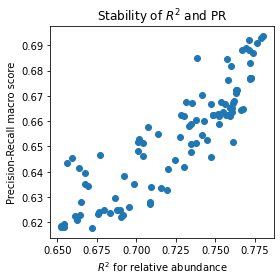

In [30]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['relative_r'].values.flatten(), 
           res['PR_score_macro'].values.flatten());
plt.xlabel('$R^2$ for relative abundance');
plt.ylabel('Precision-Recall macro score');
plt.title(r'Stability of $R^2$ and PR');
plt.tight_layout()
plt.savefig(fig_path + '/stability_relative_r.pdf')

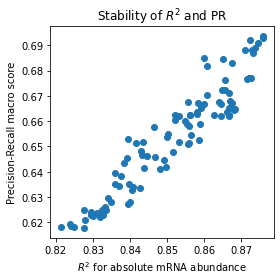

In [31]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['mRNA_r'].values.flatten(), 
           res['PR_score_macro'].values.flatten());
plt.xlabel('$R^2$ for absolute mRNA abundance');
plt.ylabel('Precision-Recall macro score');
plt.title(r'Stability of $R^2$ and PR');
plt.tight_layout()
plt.savefig(fig_path + '/stability_mRNA_r.pdf')

### Ask which parameters - relative R^2

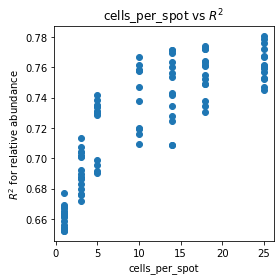

In [32]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['cells_per_spot'].values.flatten(), 
           res['relative_r'].values.flatten());
plt.xlabel('cells_per_spot');
plt.ylabel('$R^2$ for relative abundance');
plt.title(r'cells_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_relative_r_vs_cells_per_spot.pdf')

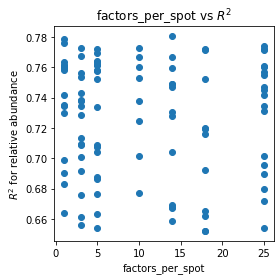

In [33]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['factors_per_spot'].values.flatten(), 
           res['relative_r'].values.flatten());
plt.xlabel('factors_per_spot');
plt.ylabel('$R^2$ for relative abundance');
plt.title(r'factors_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_relative_r_vs_factors_per_spot.pdf')

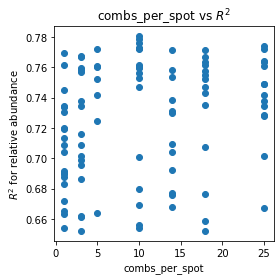

In [34]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['combs_per_spot'].values.flatten(), 
           res['relative_r'].values.flatten());
plt.xlabel('combs_per_spot');
plt.ylabel('$R^2$ for relative abundance');
plt.title(r'combs_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_relative_r_vs_combs_per_spot.pdf')

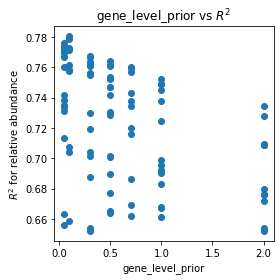

In [35]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['gene_level_prior'].values.flatten(), 
           res['relative_r'].values.flatten());
plt.xlabel('gene_level_prior');
plt.ylabel('$R^2$ for relative abundance');
plt.title(r'gene_level_prior vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_relative_r_vs_gene_level_prior.pdf')

### Ask which parameters - absolute R^2

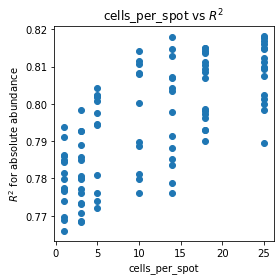

In [36]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['cells_per_spot'].values.flatten(), 
           res['absolute_r'].values.flatten());
plt.xlabel('cells_per_spot');
plt.ylabel('$R^2$ for absolute abundance');
plt.title(r'cells_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_absolute_r_vs_cells_per_spot.pdf')

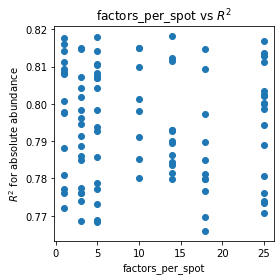

In [37]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['factors_per_spot'].values.flatten(), 
           res['absolute_r'].values.flatten());
plt.xlabel('factors_per_spot');
plt.ylabel('$R^2$ for absolute abundance');
plt.title(r'factors_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_absolute_r_vs_factors_per_spot.pdf')

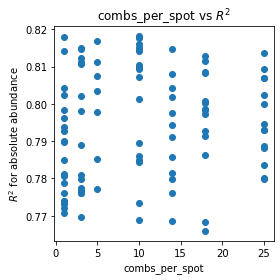

In [38]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['combs_per_spot'].values.flatten(), 
           res['absolute_r'].values.flatten());
plt.xlabel('combs_per_spot');
plt.ylabel('$R^2$ for absolute abundance');
plt.title(r'combs_per_spot vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_absolute_r_vs_combs_per_spot.pdf')

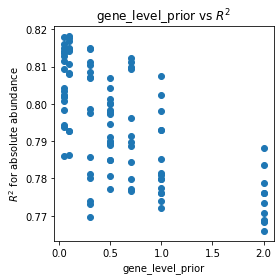

In [39]:
rcParams['figure.figsize'] = 4, 4
rcParams["axes.facecolor"] = "white"

plt.scatter(res['gene_level_prior'].values.flatten(), 
           res['absolute_r'].values.flatten());
plt.xlabel('gene_level_prior');
plt.ylabel('$R^2$ for absolute abundance');
plt.title(r'gene_level_prior vs $R^2$');
plt.tight_layout()
plt.savefig(fig_path + '/stability_absolute_r_vs_gene_level_prior.pdf')